# Multi-Class Tree:
A Basic Implementation of Multi-Class Tree Model with Explainability which includes:
- Preprocessing and encoding data
- Training a XGBoost Model
- Evaluating predictions of Multi-Class threats.
- Integrating the results into shap using the SHAP Manager Class.

In [1]:
# Check the working directory and set it to the main folder if needed.
# Set the directory to the main directory for imports.
import os
os.getcwd()

'c:\\Users\\adi_s\\Desktop\\LSTM\\UserGuides'

In [2]:
# Changing to main directory for Module imports.
os.chdir('../')

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import shap
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

We use the full dataset for Random Forest Multi-Class otherwise errors might occur due to some labels having no correct predictions.

In [4]:
# Preprocess.
data = pd.read_csv('UserGuides/Data/Cleaned_full_data.csv')
# Reset retained index.
data = data.reset_index(drop=True)
# A little bit of extra cleaning.
data['ct_ftp_cmd'] = data['ct_ftp_cmd'].fillna(0)
data['attack_cat'] = data['attack_cat'].str.replace(r'\s+', '', regex=True)
data['attack_cat'] = data['attack_cat'].str.replace('Backdoors', 'Backdoor')

C:\Users\adi_s\AppData\Local\Temp\ipykernel_13568\62178567.py:2: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('UserGuides/Data/Cleaned_full_data.csv')


The Tree Models are robust and do not require one-hot encoding. One-hot encoding and Label encoding usually yield the same results in the models. A requirement for the Random Forest is to label encode categories. Other models such as Cat-Boost can handle native string values. Here we will label encode the data and for each encoded feature store the encoder in a list so we can inverse transform them in shap. Here it is important to also encode the labels because of how shap integrates with it. If we use the string values it might be difficult to figure out in which order the Random Forest has put the labels.

In [5]:
# Label encode data2 (standard).
cols = ['proto', 'dsport', 'service', 'state', 'srcip', 'sport', 'dstip']
data[cols] = data[cols].astype(str)
le_features = []
for c in cols:
    le = LabelEncoder()
    data[c] = le.fit_transform(data[c])
    le_features.append(le)
# Keep label seperate for simplicity
le_label = LabelEncoder()
data['attack_cat'] = le_label.fit_transform(data['attack_cat'])

We split the data and drop the label columns from the X sets and use attack_cat the multi-class label as our labels.

In [6]:
X_temp = data.drop(columns=['label', 'attack_cat'])
y1 = data['attack_cat']
X_train, X_test, y_train, y_test = train_test_split(
    X_temp, y1, test_size=0.2, random_state=42)

For the purpose of this example we reduce the number of estimators which speeds up the shap value and explainer calculations but usually leads to lower accuracy overall. We use ana XGBoost model because the Random Forest tends to crash the kernel on multi-class shap value calculations.

In [7]:
xgb = XGBClassifier(n_estimators=10, random_state=42)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

In [8]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.9801952717466191
              precision    recall  f1-score   support

           0       0.50      0.03      0.06       550
           1       0.84      0.07      0.12       477
           2       0.41      0.24      0.30      3315
           3       0.61      0.86      0.71      8732
           4       0.68      0.42      0.52      4784
           5       1.00      0.98      0.99     43110
           6       0.99      1.00      1.00    443831
           7       0.92      0.79      0.85      2850
           8       0.63      0.62      0.63       320
           9       0.60      0.07      0.13        41

    accuracy                           0.98    508010
   macro avg       0.72      0.51      0.53    508010
weighted avg       0.98      0.98      0.98    508010

[[    17      0    107    354      0      1     71      0      0      0]
 [     0     32    111    323      2      0      2      4      3      0]
 [     0      1    799   2341     18     48     60     17     31  

We choose the baseline accuracy of either the test or train set. We might be better of using the training data if we wanted to try and use shap to feature engineer the data using explainability. But I am not certain about this. The Tree explainer is extremely efficient and does not require a background like the Neural Network. Infact using a background will likely slow down the calculation of shap values and cause additivity errors.

In [9]:
# We create a smaller sample to speed up the visualisations for the example.
sample = X_test.sample(n=10000)
sample = sample.reset_index(drop=True)

In [10]:
xp = shap.TreeExplainer(xgb)

We get the values for both the Explainer object for cohorts and base values and the shap values.

In [11]:
explainer = xp(sample)
shap_values = xp.shap_values(sample)

In [12]:
from Tools.shap_manager import SHAPmanager
# read docs.
help(SHAPmanager)

Help on class SHAPmanager in module Tools.shap_manager:

class SHAPmanager(builtins.object)
 |  SHAPmanager(shap_values, explainer, data, label_type=None, feature_encoder=None, label_encoder=None, feature_names=None, set_label=None)
 |
 |  SHAPmanager: A wrapper that handles multiple shap evaluation tasks. Automatically links the variable names to the correct shap array, handles differing parameters for
 |  visualisations, has grouping functions for ordinal and one hot encoded features, filtering of features, selecting labels, and restoring the data to the original form.
 |  Makes managing tasks easy without the large overhead of coding indexes.
 |
 |  Known Errors:
 |      - After restoring data make sure to set the label in multiclass using change_label function.
 |
 |  NOTE: This is a working progress..
 |
 |  Methods defined here:
 |
 |  __init__(self, shap_values, explainer, data, label_type=None, feature_encoder=None, label_encoder=None, feature_names=None, set_label=None)
 |    

For Multi-class and Tree Models that use Label Encoding we need to pass the feature label encoder and target label encoder in as parameters. Lets select DoS and evaluate it (usually we would either check correct or incorrect predictions).

In [13]:
sm = SHAPmanager(shap_values, explainer, sample, 'multi', le_features, le_label, set_label='DoS')

Plot a Summary. Large dataset sizes can take a while to plot..

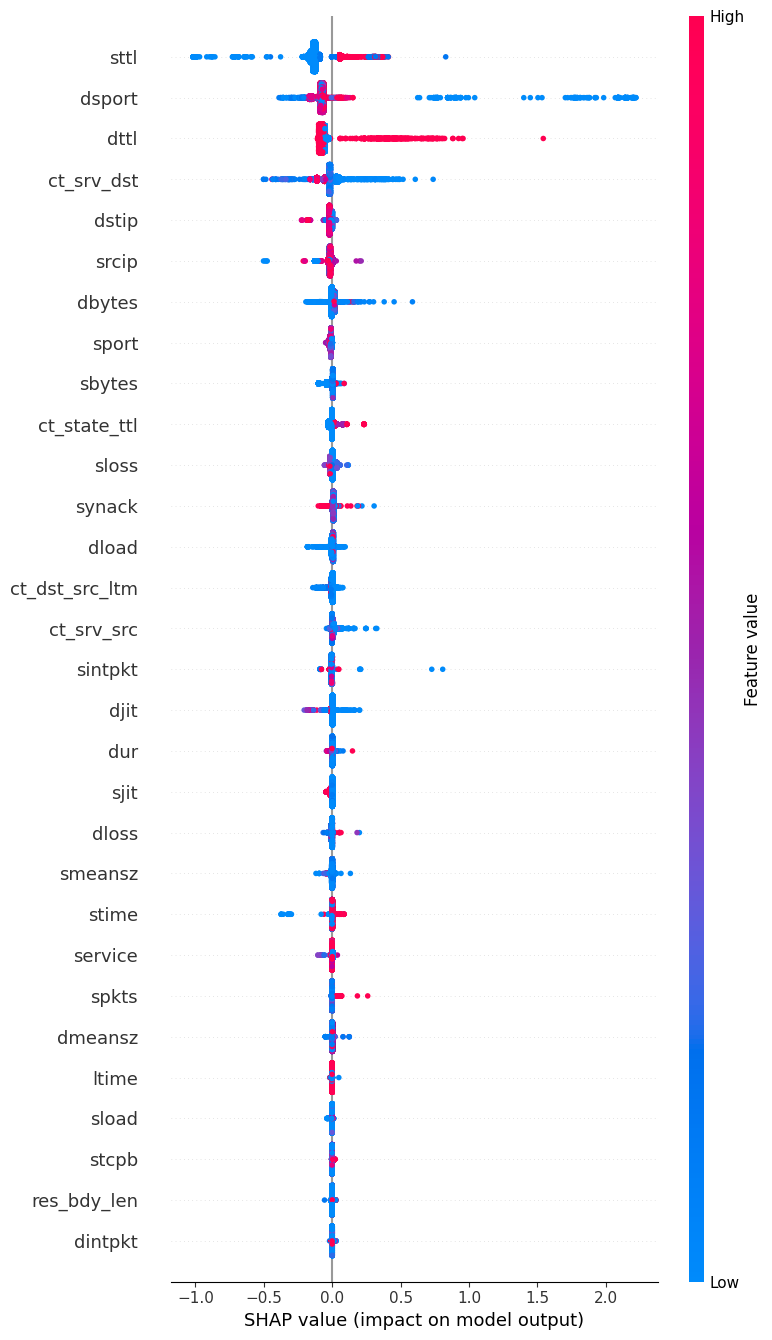

In [14]:
sm.plot_summary('summary', 30, None)

Lets check the dependence plot for D-sport. The function automatically finds the given number of interactions (4 in this case). Select either 1 or any multiples of 2.

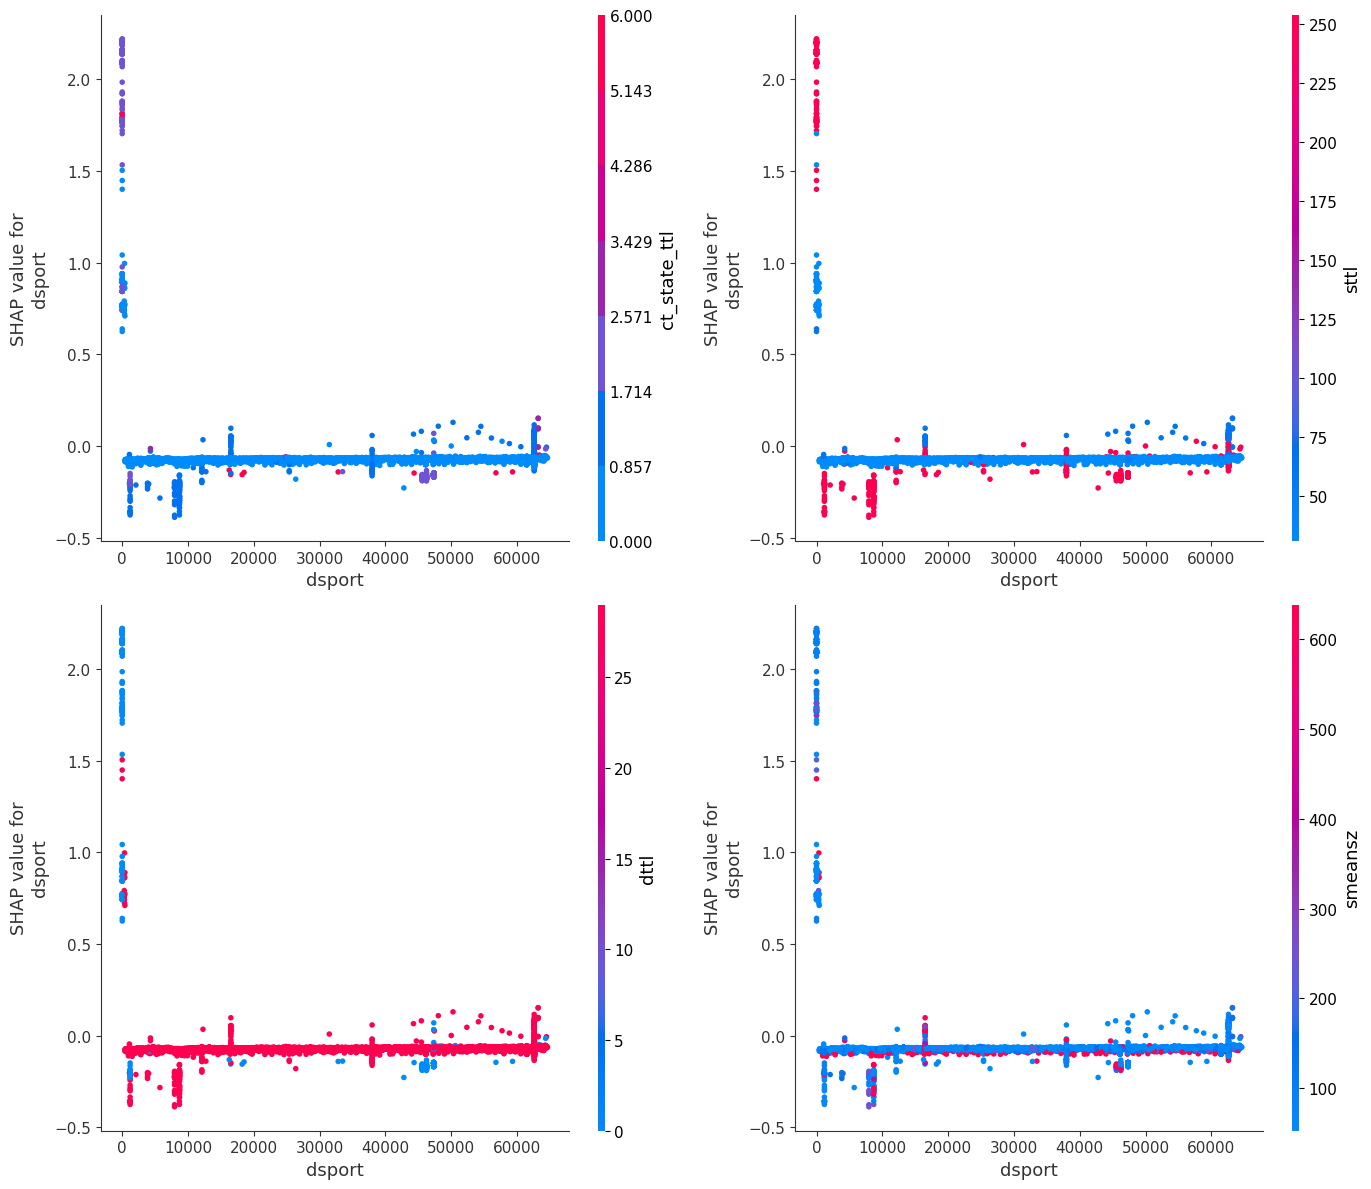

In [15]:
sm.plot_dependence('dsport', 4)

So we see dsport overall has strong interactions with ct_state_ttl, sttl, dttl, and synack for DoS predictions. What about if we check individual Destination Ports?

First we need to string encode the categorical features then use the custom group function. It will select the top 30 Destination Ports based on average absolute shap value.

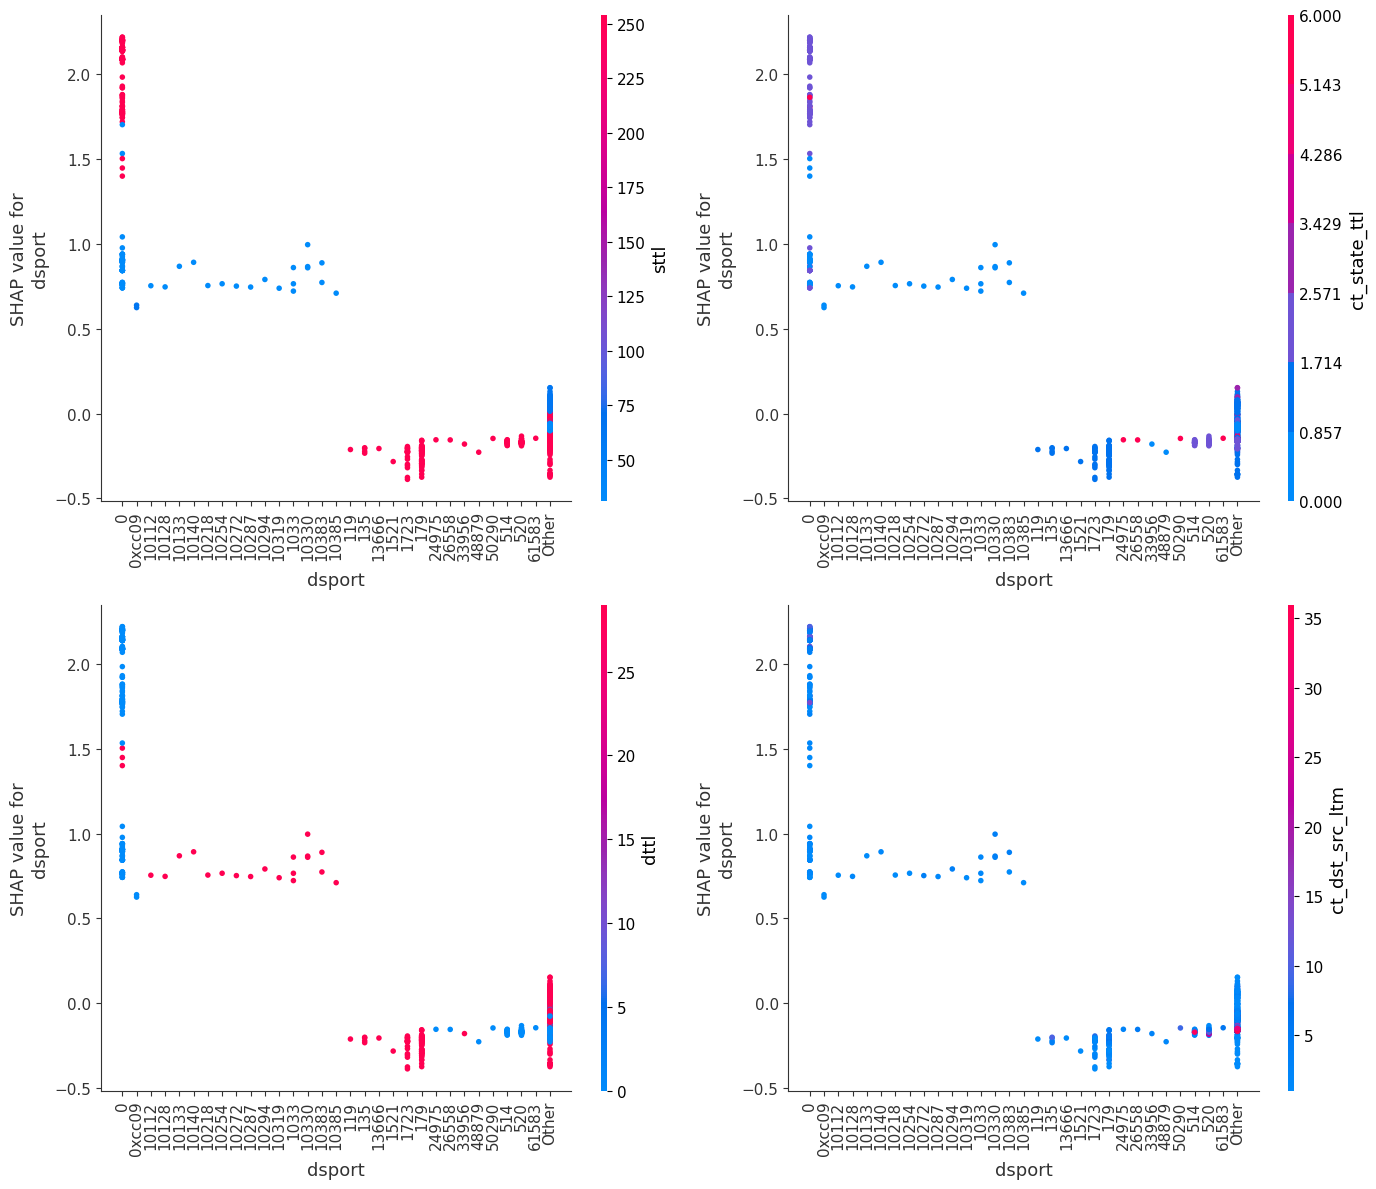

In [16]:
categories = ['proto', 'dsport', 'service', 'state', 'srcip', 'sport', 'dstip']
sm.string_encode(categories)
sm.custom_group('label_encoded', 'dsport', 30, 'average')
sm.plot_dependence('dsport', 4)

A similar result however this time it finds STATE as important too and we get a more readable output.

Once the grouping function has been used the data needs to be restored. Lets check Fuzzers by changing the label.

In [17]:
sm.restore_data()
sm.change_label('Fuzzers')

We can add custom colours using cmap to the summary plots.

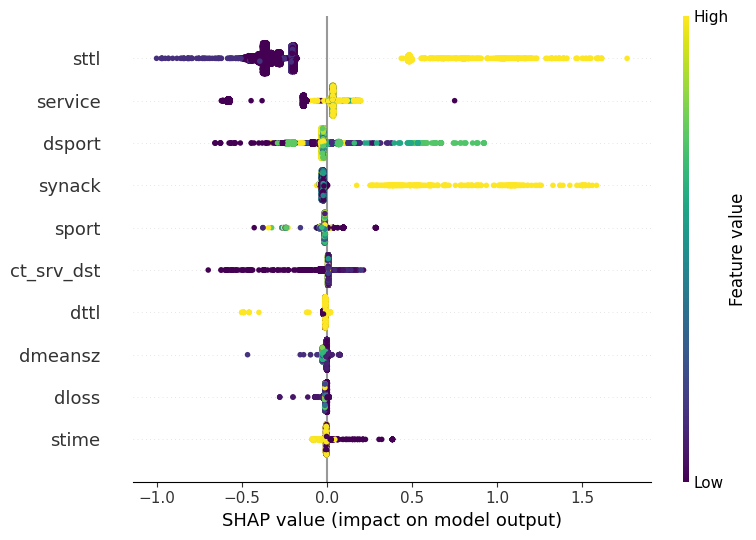

In [18]:
sm.plot_summary('summary', 10, 'viridis')

Cohorts are part of the explainer object.

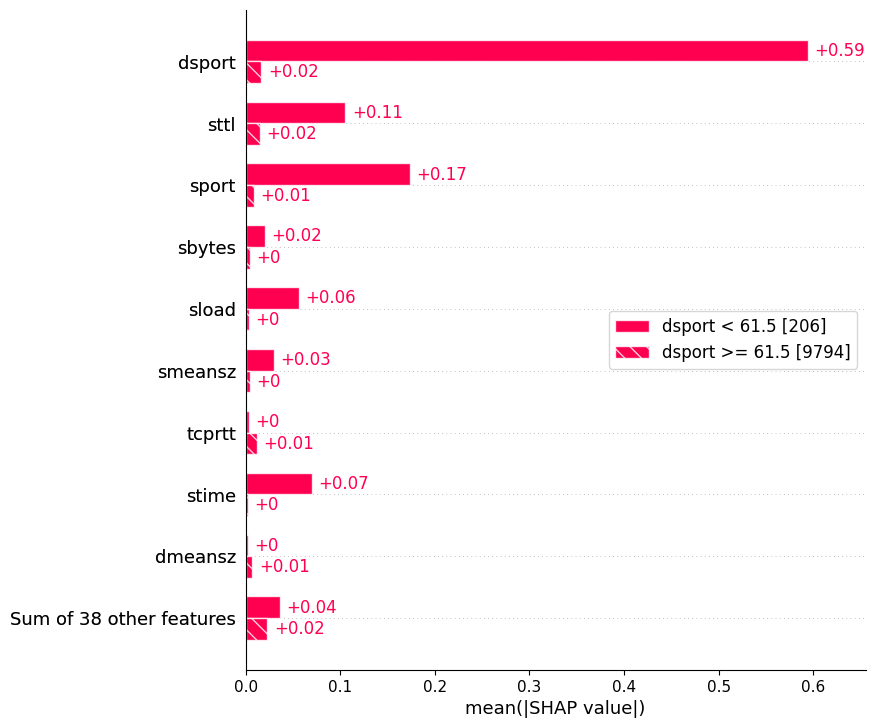

In [19]:
sm.plot_cohorts(2)

Lets check the different protocols for Fuzzers. Again we need to string encode since we restored the data.

Locator attempting to generate 3009 ticks ([0.0, ..., 2925.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 3009 ticks ([0.0, ..., 2925.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 3009 ticks ([0.0, ..., 2925.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 3009 ticks ([0.0, ..., 2925.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 3009 ticks ([0.0, ..., 2925.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 3009 ticks ([0.0, ..., 2925.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 3009 ticks ([0.0, ..., 2925.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 3009 ticks ([0.0, ..., 2925.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 3009 ticks ([0.0, ..., 2925.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 3009 ticks ([0.0, ..., 2925.0]), which exc

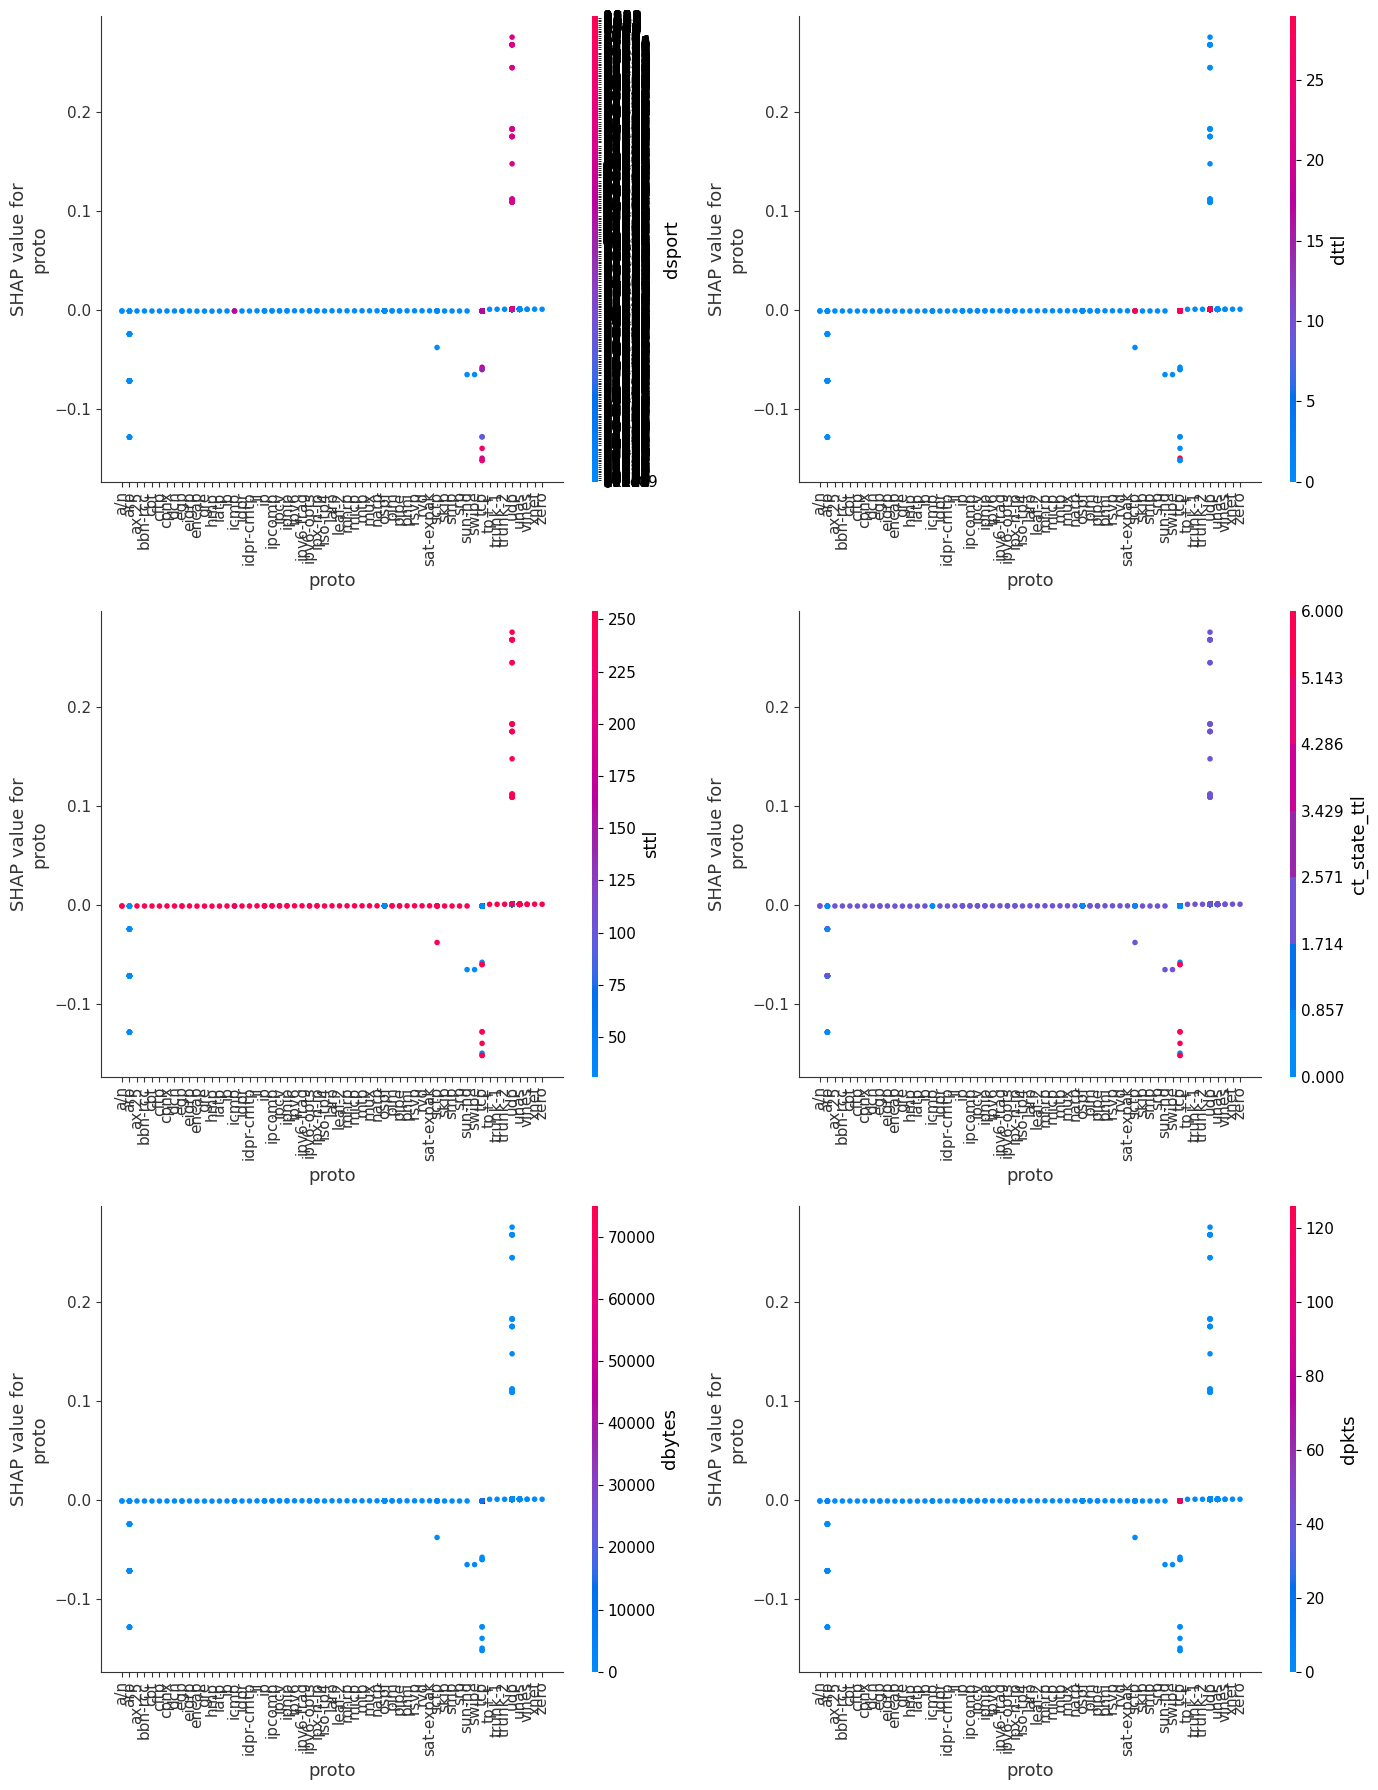

In [20]:
sm.string_encode(categories)
sm.plot_dependence('proto', 6)

An error occurs from too many values in dsport and proto. Lets customise them for better readability

In [21]:
sm.custom_group('label_encoded', 'dsport', 20, 'average')
sm.custom_group('label_encoded', 'proto', 20, 'average')

We can add custom colours to map to each unique category.

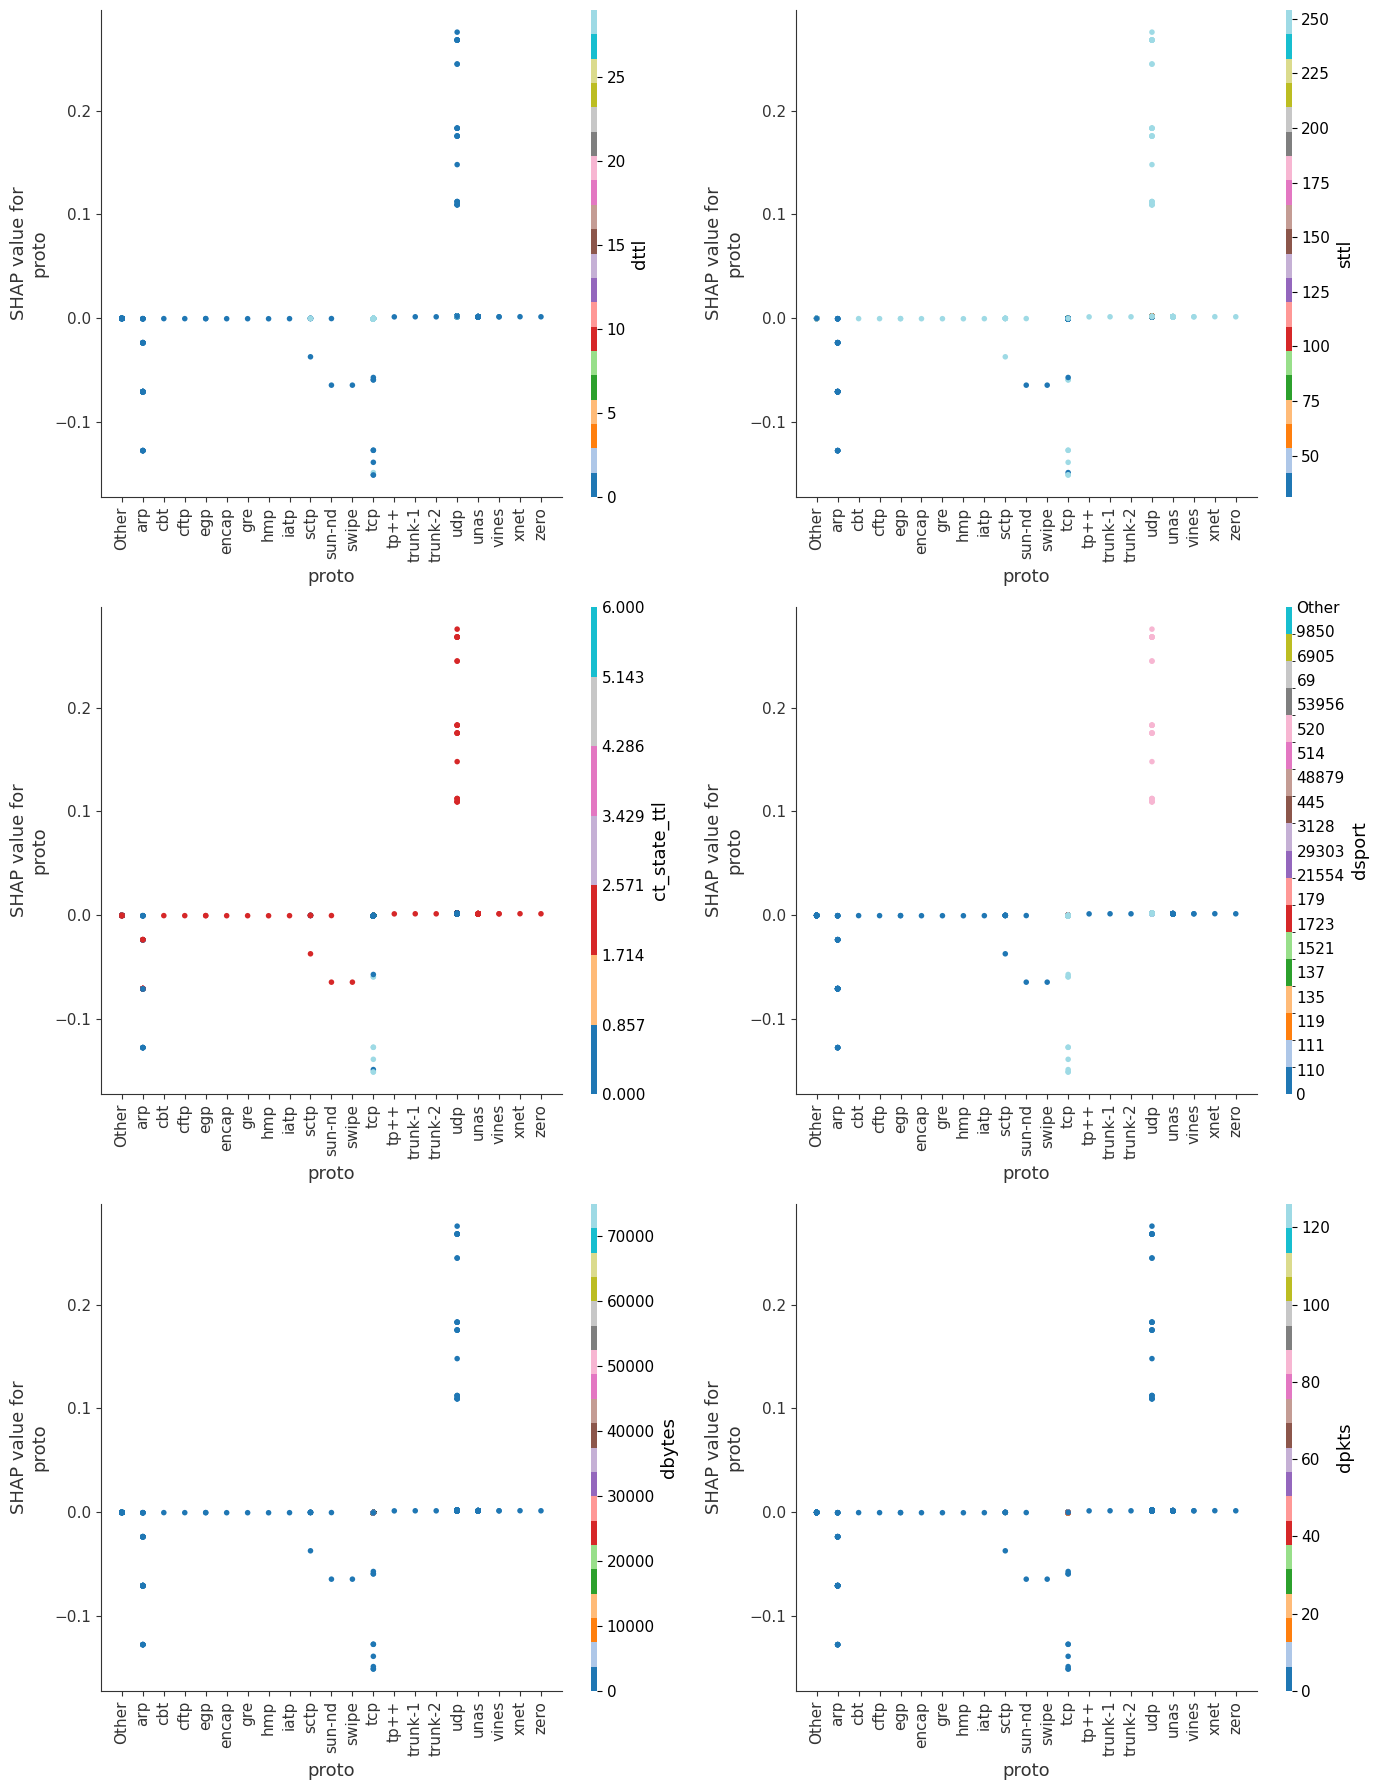

In [22]:
sm.plot_dependence('proto', 6, colour='tab20')